In [1]:
import numpy as np
import pathlib
import struct
import pandas as pd
import gc
import os.path
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from tabulate import tabulate
import csv


from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

print("Done")

Done


In [2]:
import numpy as np
import pathlib
import struct
import pandas as pd
import gc
import os.path
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from tabulate import tabulate
import csv


from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

print("Done")

Done


In [3]:
### Usable Files

direction = pathlib.Path("C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Data/Detector97/Filtered/Processed/")

# direction = pathlib.Path("C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Data/Detector97/Unfiltered/Processed/")

file_list = list(direction.iterdir())

file_num = len(file_list)

num_test_files = 2
eighty = round(0.8*file_num)
twenty = file_num-eighty - num_test_files

list_of_file_ids_train = np.arange(eighty, dtype=int)
print(list_of_file_ids_train)
list_of_file_ids_val = np.arange(eighty,eighty+twenty-num_test_files, dtype=int)

list_of_file_ids_test =np.arange(file_num-num_test_files,file_num)



[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


In [4]:
##### Functions to process the data

        ### Unnormalization of each signal individually
def Unnormalized(batch_signals):
        
        return batch_signals
        
        ### Normalization of each signal individually
def Normalized(batch_signals):

        for i in range(len(batch_signals)):
            batch_signals[i] = batch_signals[i]/np.max(batch_signals[i])
            
        return batch_signals
            
        
        ### Normalization of the entire value by one common denominator      
def Denominator(batch_signals):  
    
        denominator = 3953.48
        batch_signals = batch_signals/denominator
        
        return batch_signals


##### Class

class TrainDataset(tf.data.Dataset):

    def _generator(file_id):  
#         print(f'Using Train Class')
        if(file_id == 0):
#             print("reshuffling")
            np.random.shuffle(list_of_file_ids_train)             

        i_file = list_of_file_ids_train[file_id]

#         print(f'file_id: {file_id}, i_file: {i_file}')
#         print()
        signal_filename = direction/f'{i_file+1}.h5'

        
         # Load the labels and signals from the files
        df = pd.read_hdf(signal_filename,key=None)  
        
        labels1 = df.iloc[:,9].values
        labels2 = df['ToF'].values
        labels = labels1+labels2
        
        signals = df[df.columns[10:-2]].values
        
        
        # Determine how many batches can be made from this file
        num_batches = len(signals) // batch_size

        # Shuffle the signals within the file
        signal_indices = np.arange(len(signals))
        np.random.shuffle(signal_indices)        
        
        # Loop through each batch in the file
        for batch_idx in range(num_batches):
            # Get the signals and labels for this batch
            batch_signal_indices = signal_indices[batch_idx*batch_size:(batch_idx+1)*batch_size]      
 
            batch_signals = signals[batch_signal_indices]
            
            batch_signals = Processing[process](batch_signals)
                
            batch_signals = batch_signals[:,:,np.newaxis] # Can also be done with signals = signals[:,:,np.newaxis]
            batch_labels = labels[batch_signal_indices]

            # Yield the signals and labels as a tuple
            yield batch_signals, batch_labels 
             
    def __new__(cls, file_id):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=(tf.dtypes.float64, tf.dtypes.float64),
            output_shapes=((batch_size, 1998,1), (batch_size, )),
            args=(file_id,)
        )
    
class ValDataset(tf.data.Dataset):

    def _generator(file_id):  
#         print(f'Using Val Class')
        i_file = list_of_file_ids_val[file_id]
    
        signal_filename = direction/f'{i_file+1}.h5'

         # Load the labels and signals from the files
        df = pd.read_hdf(signal_filename,key=None)    
        
        labels1 = df.iloc[:,9].values
        labels2 = df['ToF'].values
        labels = labels1+labels2
        
        signals = df[df.columns[10:-2]].values
        
        
        # Determine how many batches can be made from this file
        num_batches = len(signals) // batch_size

        # Shuffle the signals within the file
        signal_indices = np.arange(len(signals))
        np.random.shuffle(signal_indices)        
        
        # Loop through each batch in the file
        for batch_idx in range(num_batches):
            # Get the signals and labels for this batch
            batch_signal_indices = signal_indices[batch_idx*batch_size:(batch_idx+1)*batch_size]      
 
            batch_signals = signals[batch_signal_indices]
            
            batch_signals = Processing[process](batch_signals)
                
            batch_signals = batch_signals[:,:,np.newaxis] # Can also be done with signals = signals[:,:,np.newaxis]
            batch_labels = labels[batch_signal_indices]

            # Yield the signals and labels as a tuple
            yield batch_signals, batch_labels
             
    def __new__(cls, file_id):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=(tf.dtypes.float64, tf.dtypes.float64),
            output_shapes=((batch_size, 1998,1), (batch_size, )),
            args=(file_id,)
        )

In [5]:
# Pre-processing options
Processing = {
    "Unnormalized": Unnormalized,
    "Normalized": Normalized,
    "Denominator": Denominator
}
Process = ["Unnormalized","Normalized","Denominator"]
process = Process[2]
# Loss Function

loss_function = ['mean_absolute_error','mean_squared_error']
lf = 1

# Training Variables
batch_size = 32
num_epochs = 30

steps_per_epoch = eighty*5000 // batch_size

# Learning Rate
initial_lr = 1e-03
final_lr = 1e-06

# initial_lr = 1e-03
# final_lr = 1e-03

def step_decay(epoch):
    lrate = initial_lr * (final_lr/initial_lr)**(epoch/num_epochs)

    print(f'Current Learning rate: {lrate}')
    return lrate

# Compile the model
# model.compile(loss=loss_function[lf], optimizer = keras.optimizers.Adam(initial_lr), metrics=['mean_absolute_error','mean_squared_error'])

# Configuring training dataset
dataset_train = tf.data.Dataset.range(eighty).interleave(
        TrainDataset,
        cycle_length=2,
        num_parallel_calls=2,
        deterministic=True).repeat().prefetch(1)



# Configuring training dataset
dataset_val = tf.data.Dataset.range(twenty-num_test_files).interleave(
        ValDataset,
        cycle_length=2,
        num_parallel_calls=2,
        deterministic=True).prefetch(1)


# Callback Functions
LRS = tf.keras.callbacks.LearningRateScheduler(step_decay)

ES = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True,verbose=1)

CSV = tf.keras.callbacks.CSVLogger("C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Data/Log.csv",
                                separator=",", append=True)

# MC_path = f"C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Trainings/model_checkpoint_{run + 1}.h5"
# MC = ModelCheckpoint(
#     filepath=MC_path,  # Filepath to save the model weights
#     monitor='val_loss',  # Quantity to monitor (e.g., validation loss)
#     save_best_only=True,  # Save only the best model based on the monitored quantity
#     save_weights_only=True  # Save only the model weights, not the entire model
# )

# callbacks = [MC,LRS,CSV]




Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


In [6]:
def create_model():
    model = keras.models.Sequential()
    model.add(Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=(1998, 1)))
    model.add(Conv1D(filters=8, kernel_size=5, dilation_rate=2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=4, kernel_size=5, dilation_rate=2, activation='relu'))
    model.add(Conv1D(filters=4, kernel_size=5, strides=2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=4, kernel_size=3, strides=2))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    return model

In [7]:
model = create_model()

In [22]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import load_model

# Define the path to the files
MC_path = "C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Trainings/MCPGN"
process = Process[2]


# Get the list of model file names
file_models = os.listdir(MC_path)

# Initialize lists to store the metrics for each model
mae_per_model = []
mse_per_model = []
mean_per_model = []
std_per_model = []

# Process the data and calculate metrics for each model and each test file
for run, model_file in enumerate(file_models):
    print(f"Run {run + 1}/{len(file_models)}")

    # Load the model weights
    weights_path = os.path.join(MC_path, model_file)
    model = create_model()
    model.load_weights(weights_path)

    # Initialize lists to store the metrics for each test file
    mae_per_test_file = []
    mse_per_test_file = []
    mean_per_test_file = []
    std_per_test_file = []

    # Process the data and calculate metrics for each test file
    for file_id in list_of_file_ids_test:
        print(f"Processing file ID: {file_id}")

        # Load the data from the file
        file_path = os.path.join(MC_path, file_list[file_id])
        df_test = pd.read_hdf(file_path, key=None)

        # Extract labels and signals for the i-th model
        labels1 = df_test.iloc[:, 9].values
        labels2 = df_test['ToF'].values
        labels = labels1 + labels2

        signals = df_test[df_test.columns[10:-2]].values
        signals = Processing[process](signals)
        signals = signals[:, :, np.newaxis]

        predicted = model.predict(signals)
        predicted = np.squeeze(predicted)
        true = labels

        difference = predicted - true

        # Calculate metrics for the i-th model and test file
        mae = mean_absolute_error(true, predicted)
        mse = mean_squared_error(true, predicted)
        mean = np.mean(predicted-true)
        std = np.std(predicted-true)

        # Append metrics to the respective lists
        mae_per_test_file.append(mae)
        mse_per_test_file.append(mse)
        mean_per_test_file.append(mean)
        std_per_test_file.append(std)

        # Print metrics for the i-th model and test file
        print(f"Metrics for Model {model_file}, File {file_id}:")
        print("MAE:", mae)
        print("MSE:", mse)
        print("Mean:", mean)
        print("STD:", std)
        print()

    # Calculate metrics for all test files for the current model
    combined_mae = np.mean(mae_per_test_file)
    combined_mse = np.mean(mse_per_test_file)
    combined_mean = np.mean(mean_per_test_file)
    combined_std = np.mean(std_per_test_file)

    # Append metrics for the current model to the respective lists
    mae_per_model.append(combined_mae)
    mse_per_model.append(combined_mse)
    mean_per_model.append(combined_mean)
    std_per_model.append(combined_std)

# Calculate metrics for all models combined
combined_mae = np.mean(mae_per_model)
combined_mse = np.mean(mse_per_model)
combined_mean = np.mean(mean_per_model)
combined_std = np.mean(std_per_model)

# Calculate errors for combined metrics
combined_mae_error = np.std(mae_per_model)
combined_mse_error = np.std(mse_per_model)
combined_mean_error = np.std(mean_per_model)
combined_std_error = np.std(std_per_model)

# Print metrics for all models combined
print("Metrics for All Models Combined:")
print(f"Combined MAE: {combined_mae:.3f} \u00B1 {combined_mae_error:.3f}")
print(f"Combined MSE: {combined_mse:.3f} \u00B1 {combined_mse_error:.3f}")
print(f"Combined Mean: {combined_mean:.3f} \u00B1 {combined_mean_error:.3f}")
print(f"Combined STD: {combined_std:.3f} \u00B1 {combined_std_error:.3f}")

Run 1/5
Processing file ID: 38
Metrics for Model model_checkpoint_1.h5, File 38:
MAE: 0.07462329407297613
MSE: 0.010466360027348165
Mean: -0.0024566433076178788
STD: 0.10227572992165493

Processing file ID: 39
Metrics for Model model_checkpoint_1.h5, File 39:
MAE: 0.07306330284068634
MSE: 0.00969596204464839
Mean: -0.0021990906716925986
STD: 0.09844351702812158

Run 2/5
Processing file ID: 38
Metrics for Model model_checkpoint_2.h5, File 38:
MAE: 0.07468473599577675
MSE: 0.010488242461794786
Mean: 0.0021769402803807785
STD: 0.1023889808173245

Processing file ID: 39
Metrics for Model model_checkpoint_2.h5, File 39:
MAE: 0.07370008776009027
MSE: 0.009876219341490206
Mean: 0.0016925637009376226
STD: 0.09936475516805983

Run 3/5
Processing file ID: 38
Metrics for Model model_checkpoint_3.h5, File 38:
MAE: 0.07430824275508724
MSE: 0.010567046714944763
Mean: 0.0012258495750951386
STD: 0.10278883211596483

Processing file ID: 39
Metrics for Model model_checkpoint_3.h5, File 39:
MAE: 0.073087

In [8]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import load_model

df_test = pd.concat([pd.read_hdf(file_list[i], key=None) for i in list_of_file_ids_test])


# Set the path
MC_path = "C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Trainings/MCPGN"
process = Process[2]

# MC_path = "C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Trainings/MCPIN"
# process = Process[1]

# Get the number of files in the path
file_models = os.listdir(MC_path)
num_files = len(file_models)

# Get the number of runs
num_runs = 5

# Initialize lists to store the metrics for each model
mae_per_model = []
mse_per_model = []
mean_per_model = []
std_per_model = []

# Process the data and calculate metrics for each model
for run in range(len(file_models)):
    print(f"Run {run + 1}/{len(file_models)}")
    
    # Load the model weights
    weights_path = os.path.join(MC_path, file_models[run])
    model = create_model()
    model.load_weights(weights_path)
    
    # Extract labels and signals for the i-th model
    labels1 = df_test.iloc[:, 9].values
    labels2 = df_test['ToF'].values
    labels = labels1 + labels2

    signals = df_test[df_test.columns[10:-2]].values
    signals = Processing[process](signals)
    signals = signals[:, :, np.newaxis]

    predicted = model.predict(signals)
    predicted = np.squeeze(predicted)
    true = labels

    difference = predicted - true

    # Calculate metrics for the i-th model
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    mean = np.mean(predicted-true)
    std = np.std(predicted-true)

    # Append metrics to the respective lists
    mae_per_model.append(mae)
    mse_per_model.append(mse)
    mean_per_model.append(mean)
    std_per_model.append(std)

    # Print metrics for the i-th model
    print(f"Metrics for Model {run+1}:")
    print("MAE:", mae)
    print("MSE:", mse)
    print("Mean:", mean)
    print("STD:", std)
    print()

# Calculate metrics for all models combined
combined_mae = np.mean(mae_per_model)
combined_mse = np.mean(mse_per_model)
combined_mean = np.mean(mean_per_model)
combined_std = np.mean(std_per_model)

# Calculate errors for combined metrics
combined_mae_error = np.std(mae_per_model)
combined_mse_error = np.std(mse_per_model)
combined_mean_error = np.std(mean_per_model)
combined_std_error = np.std(std_per_model)

# Print metrics for all models combined
print("Metrics for All Models Combined:")
print(f"Combined MAE: {combined_mae:.3f} \u00B1 {combined_mae_error:.3f}")
print(f"Combined MSE: {combined_mse:.3f} \u00B1 {combined_mse_error:.3f}")
print(f"Combined Mean: {combined_mean:.3f} \u00B1 {combined_mean_error:.3f}")
print(f"Combined STD: {combined_std:.3f} \u00B1 {combined_std_error:.3f}")

Run 1/5
Metrics for Model 1:
MAE: 0.07384318208010429
MSE: 0.010081103563626763
Mean: -0.0023278477760005968
STD: 0.10037771011712975

Run 2/5
Metrics for Model 2:
MAE: 0.07419233842230344
MSE: 0.010182185244175919
Mean: 0.0019347158557375729
STD: 0.10088826551553692

Run 3/5
Metrics for Model 3:
MAE: 0.07369755938580703
MSE: 0.010166036212197999
Mean: 0.0006337946197990627
STD: 0.10082477134403982

Run 4/5
Metrics for Model 4:
MAE: 0.08424515742285274
MSE: 0.012701056572233787
Mean: -0.03359977939205004
STD: 0.10757374864268399

Run 5/5
Metrics for Model 5:
MAE: 0.0790138456640222
MSE: 0.011259671906674429
Mean: -0.00891863230581686
STD: 0.10573613339094667

Metrics for All Models Combined:
Combined MAE: 0.077 ± 0.004
Combined MSE: 0.011 ± 0.001
Combined Mean: -0.008 ± 0.013
Combined STD: 0.103 ± 0.003


In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

df_test = pd.concat([pd.read_hdf(file_list[i], key=None) for i in list_of_file_ids_test])
unique_mass_test = df_test['A'].unique()

# Initialize lists to store the metrics for each unique combination of mass and energy
metrics_per_combination = []

# Test Set
for mass_test in unique_mass_test:
    print(f"Unique Mass: {mass_test}")
    df_intermediate = df_test[df_test['A'] == mass_test]
    unique_energy = df_intermediate['Z'].unique()

    for energy in unique_energy:
        print(f"Unique Energy: {energy}")

        # Initialize lists to store the metrics for the current combination of mass and energy
        mae_per_model_combination = []
        mse_per_model_combination = []
        mean_per_model_combination = []
        std_per_model_combination = []
        num_signals = 0

        for run in range(len(file_models)):
            # Load the model weights
            weights_path = os.path.join(MC_path, file_models[run])
            model = create_model()
            model.load_weights(weights_path)

            # Extract labels and signals for the i-th model
            labels1 = df_intermediate[df_intermediate['Z'] == energy].iloc[:, 9].values
            labels2 = df_intermediate[df_intermediate['Z'] == energy]['ToF'].values
            labels = labels1 + labels2

            signals = df_intermediate[df_intermediate['Z'] == energy][df_intermediate.columns[10:-2]].values
            signals = Processing[process](signals)
            signals = signals[:, :, np.newaxis]

            predicted = model.predict(signals)
            predicted = np.squeeze(predicted)
            true = labels

            difference = predicted - true

            # Calculate metrics for the i-th model and the current combination of mass and energy
            mae = mean_absolute_error(true, predicted)
            mse = mean_squared_error(true, predicted)
            mean = np.mean(predicted - true)
            std = np.std(predicted - true)

            # Append metrics to the respective lists
            mae_per_model_combination.append(mae)
            mse_per_model_combination.append(mse)
            mean_per_model_combination.append(mean)
            std_per_model_combination.append(std)
            num_signals = len(signals)

        # Calculate metrics for the current combination of mass and energy
        combined_mae = np.mean(mae_per_model_combination)
        combined_mse = np.mean(mse_per_model_combination)
        combined_mean = np.mean(mean_per_model_combination)
        combined_std = np.mean(std_per_model_combination)

        # Calculate errors for combined metrics
        combined_mae_error = np.std(mae_per_model_combination)
        combined_mse_error = np.std(mse_per_model_combination)
        combined_mean_error = np.std(mean_per_model_combination)
        combined_std_error = np.std(std_per_model_combination)

        # Append metrics for the current combination of mass and energy to the main list
        metrics_per_combination.append((mass_test, energy, combined_mae, combined_mae_error, combined_mse, combined_mse_error, combined_mean, combined_mean_error, combined_std, combined_std_error, num_signals))

# Print metrics for all unique combinations of mass and energy
print("Metrics for All Unique Combinations of Mass and Energy:")
for combination in metrics_per_combination:
    mass_test, energy, combined_mae, combined_mae_error, combined_mse, combined_mse_error, combined_mean, combined_mean_error, combined_std, combined_std_error, num_signals = combination
    print(f"Mass: {mass_test}, Energy: {energy}")
    print(f"Combined MAE: {combined_mae} ± {combined_mae_error}")
    print(f"Combined MSE: {combined_mse} ± {combined_mse_error}")
    print(f"Combined Mean: {combined_mean} ± {combined_mean_error}")
    print(f"Combined STD: {combined_std} ± {combined_std_error}")
    print(f"Number of signals: {num_signals}")
    print()

Unique Mass: 100.0
Unique Energy: 108
Unique Energy: 34
Unique Energy: 41
Unique Energy: 48
Unique Energy: 58
Unique Energy: 68
Unique Energy: 78
Unique Energy: 88
Unique Energy: 98
Unique Mass: 104.0
Unique Energy: 22
Unique Energy: 30
Unique Energy: 38
Unique Energy: 46
Unique Energy: 54
Unique Energy: 62
Unique Mass: 105.0
Unique Energy: 103
Unique Energy: 61
Unique Energy: 72
Unique Energy: 82
Unique Energy: 93
Unique Mass: 110.0
Unique Energy: 47
Unique Energy: 63
Unique Energy: 64
Unique Energy: 75
Unique Energy: 86
Unique Energy: 97
Unique Mass: 127.0
Unique Energy: 52
Unique Energy: 61
Unique Mass: 130.0
Unique Energy: 28
Unique Energy: 38
Unique Energy: 48
Unique Energy: 58
Unique Energy: 68
Unique Energy: 76
Unique Energy: 78
Unique Energy: 89
Unique Mass: 133.0
Unique Energy: 55
Unique Energy: 65
Unique Mass: 135.0
Unique Energy: 79
Unique Mass: 136.0
Unique Energy: 38
Unique Energy: 48
Unique Energy: 58
Unique Energy: 68
Unique Energy: 78
Unique Mass: 140.0
Unique Energy: 4

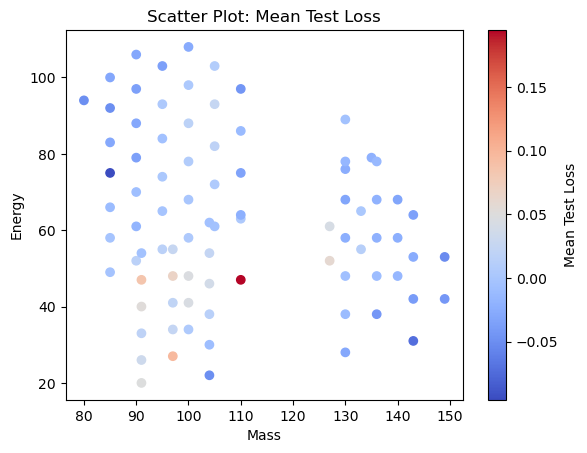

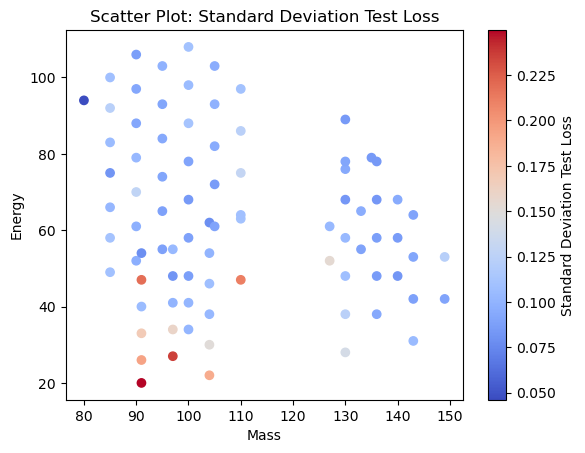

In [10]:
import matplotlib.pyplot as plt

# Initialize lists to store the values for scatter plots
mass_list = []
energy_list = []
mean_loss_list = []
std_loss_list = []

# Extract the mass, energy, mean, std, and num_signals values from the metrics_per_combination list
for combination in metrics_per_combination:
    mass_test, energy, combined_mae, combined_mae_error, combined_mse, combined_mse_error, combined_mean, combined_mean_error, combined_std, combined_std_error, num_signals = combination
    
    # Append the values to the respective lists
    mass_list.append(mass_test)
    energy_list.append(energy)
    mean_loss_list.append(combined_mean)
    std_loss_list.append(combined_std)

# Scatter plot for Mean Test Loss
plt.figure()
plt.scatter(mass_list, energy_list, c=mean_loss_list, cmap='coolwarm')
plt.colorbar(label='Mean Test Loss')
plt.xlabel('Mass')
plt.ylabel('Energy')
plt.title('Scatter Plot: Mean Test Loss')
plt.show()

# Scatter plot for Standard Deviation Test Loss
plt.figure()
plt.scatter(mass_list, energy_list, c=std_loss_list, cmap='coolwarm')
plt.colorbar(label='Standard Deviation Test Loss')
plt.xlabel('Mass')
plt.ylabel('Energy')
plt.title('Scatter Plot: Standard Deviation Test Loss')
plt.show()

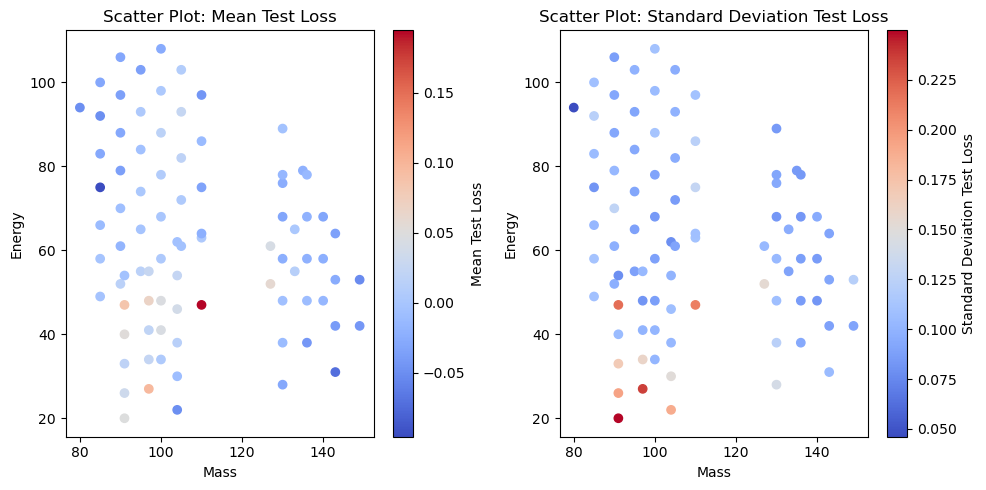

In [11]:
import matplotlib.pyplot as plt

# Initialize lists to store the values for scatter plots
mass_list = []
energy_list = []
mean_loss_list = []
std_loss_list = []

# Extract the mass, energy, mean, std, and num_signals values from the metrics_per_combination list
for combination in metrics_per_combination:
    mass_test, energy, combined_mae, combined_mae_error, combined_mse, combined_mse_error, combined_mean, combined_mean_error, combined_std, combined_std_error, num_signals = combination
    
    # Append the values to the respective lists
    mass_list.append(mass_test)
    energy_list.append(energy)
    mean_loss_list.append(combined_mean)
    std_loss_list.append(combined_std)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Scatter plot for Mean Test Loss
scatter1 = ax1.scatter(mass_list, energy_list, c=mean_loss_list, cmap='coolwarm')
ax1.set_xlabel('Mass')
ax1.set_ylabel('Energy')
ax1.set_title('Scatter Plot: Mean Test Loss')
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Mean Test Loss')

# Scatter plot for Standard Deviation Test Loss
scatter2 = ax2.scatter(mass_list, energy_list, c=std_loss_list, cmap='coolwarm')
ax2.set_xlabel('Mass')
ax2.set_ylabel('Energy')
ax2.set_title('Scatter Plot: Standard Deviation Test Loss')
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('Standard Deviation Test Loss')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

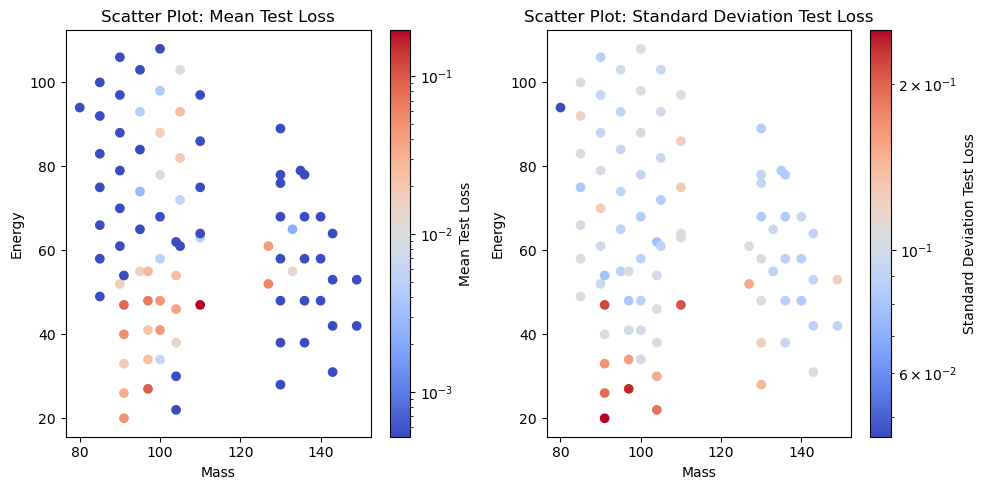

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import copy

# Initialize lists to store the values for scatter plots
mass_list = []
energy_list = []
mean_loss_list = []
std_loss_list = []

# Extract the mass, energy, mean, std, and num_signals values from the metrics_per_combination list
for combination in metrics_per_combination:
    mass_test, energy, combined_mae, combined_mae_error, combined_mse, combined_mse_error, combined_mean, combined_mean_error, combined_std, combined_std_error, num_signals = combination
    
    # Append the values to the respective lists
    mass_list.append(mass_test)
    energy_list.append(energy)
    mean_loss_list.append(combined_mean)
    std_loss_list.append(combined_std)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Scatter plot for Mean Test Loss
scatter1 = ax1.scatter(mass_list, energy_list, c=mean_loss_list, cmap='coolwarm',norm=colors.LogNorm())
ax1.set_xlabel('Mass')
ax1.set_ylabel('Energy')
ax1.set_title('Scatter Plot: Mean Test Loss')
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Mean Test Loss')

# Scatter plot for Standard Deviation Test Loss
scatter2 = ax2.scatter(mass_list, energy_list, c=std_loss_list, cmap='coolwarm',norm=colors.LogNorm())
ax2.set_xlabel('Mass')
ax2.set_ylabel('Energy')
ax2.set_title('Scatter Plot: Standard Deviation Test Loss')
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('Standard Deviation Test Loss')

# Create a custom colormap with blue as the color for 'bad' values
my_cmap = copy.copy(plt.cm.get_cmap('coolwarm'))
my_cmap.set_bad(my_cmap(0))

# Apply the custom colormap to the scatter plots
scatter1.set_cmap(my_cmap)
scatter2.set_cmap(my_cmap)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

Run 1/5
Run 2/5
Run 3/5
Run 4/5
Run 5/5


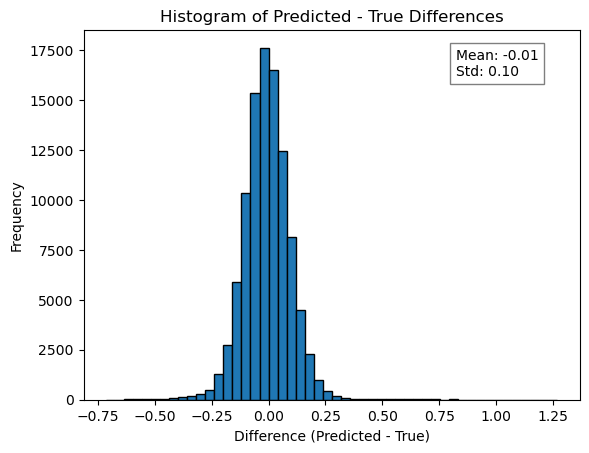

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import load_model

df_test = pd.concat([pd.read_hdf(file_list[i], key=None) for i in list_of_file_ids_test])


# Get the number of files in the path
file_models = os.listdir(MC_path)
num_files = len(file_models)

# Get the number of runs
num_runs = 5

# Initialize a list to store the differences between predicted and true values
differences = []

# Process the data and calculate differences for each model
for run in range(len(file_models)):
    print(f"Run {run + 1}/{len(file_models)}")
    
    # Load the model weights
    weights_path = os.path.join(MC_path, file_models[run])
    model = create_model()
    model.load_weights(weights_path)
    
    # Extract labels and signals for the i-th model
    labels1 = df_test.iloc[:, 9].values
    labels2 = df_test['ToF'].values
    labels = labels1 + labels2

    signals = df_test[df_test.columns[10:-2]].values
    signals = Processing[process](signals)
    signals = signals[:, :, np.newaxis]

    predicted = model.predict(signals)
    predicted = np.squeeze(predicted)
    true = labels

    difference = predicted - true
    
    # Append the differences to the list
    differences.extend(difference)
    
    
# Calculate mean and standard deviation of the differences
mean_difference = np.mean(differences)
std_difference = np.std(differences)

# Create a histogram of the differences
plt.hist(differences, bins=50, edgecolor='black')
plt.xlabel('Difference (Predicted - True)')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted - True Differences')

# Add text box with mean and standard deviation
text_box = f"Mean: {mean_difference:.2f}\nStd: {std_difference:.2f}"
plt.text(0.75, 0.95, text_box, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.show()

Run 1/5
Run 2/5
Run 3/5
Run 4/5
Run 5/5


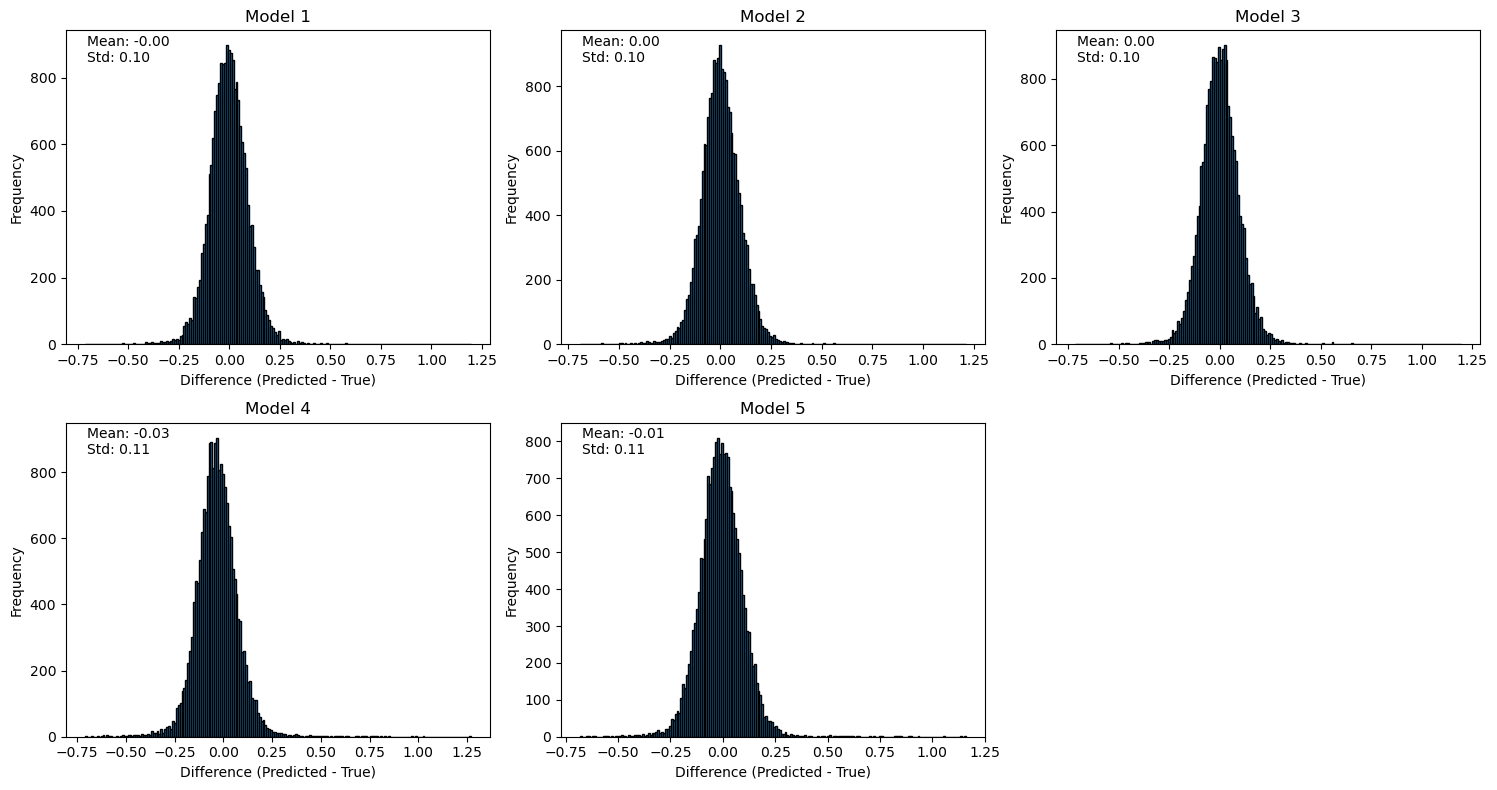

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import load_model

df_test = pd.concat([pd.read_hdf(file_list[i], key=None) for i in list_of_file_ids_test])

# Get the number of files in the path
file_models = os.listdir(MC_path)
num_files = len(file_models)

# Get the number of runs
num_runs = 5

# Create a figure with a 2x3 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Process the data and plot histograms for each model
for run, ax in zip(range(len(file_models)), axes.flatten()[:-1]):
    print(f"Run {run + 1}/{len(file_models)}")
    
    # Load the model weights
    weights_path = os.path.join(MC_path, file_models[run])
    model = create_model()
    model.load_weights(weights_path)
    
    # Extract labels and signals for the i-th model
    labels1 = df_test.iloc[:, 9].values
    labels2 = df_test['ToF'].values
    labels = labels1 + labels2

    signals = df_test[df_test.columns[10:-2]].values
    signals = Processing[process](signals)
    signals = signals[:, :, np.newaxis]

    predicted = model.predict(signals)
    predicted = np.squeeze(predicted)
    true = labels

    difference = predicted - true
    
    # Create a histogram for the differences
    ax.hist(difference, bins=200, edgecolor='black')
    ax.set_xlabel('Difference (Predicted - True)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Model {run + 1}')
    
    # Calculate and display the mean and standard deviation
    mean = np.mean(difference)
    std = np.std(difference)
    ax.text(0.05, 0.9, f'Mean: {mean:.2f}\nStd: {std:.2f}', transform=ax.transAxes)

# Remove the empty subplot in the second row
fig.delaxes(axes[1, -1])

# Adjust the spacing between subplots
plt.tight_layout()

plt.show()

Run 1/5
Run 2/5
Run 3/5
Run 4/5
Run 5/5


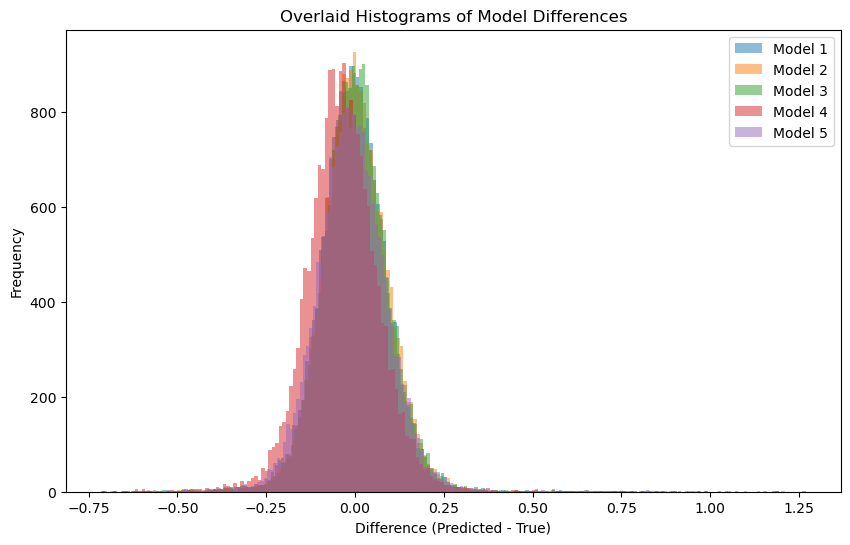

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import load_model

df_test = pd.concat([pd.read_hdf(file_list[i], key=None) for i in list_of_file_ids_test])

# Get the number of files in the path
file_models = os.listdir(MC_path)
num_files = len(file_models)

# Get the number of runs
num_runs = 5

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Process the data and plot overlaid histograms for each model
for run in range(len(file_models)):
    print(f"Run {run + 1}/{len(file_models)}")
    
    # Load the model weights
    weights_path = os.path.join(MC_path, file_models[run])
    model = create_model()
    model.load_weights(weights_path)
    
    # Extract labels and signals for the i-th model
    labels1 = df_test.iloc[:, 9].values
    labels2 = df_test['ToF'].values
    labels = labels1 + labels2

    signals = df_test[df_test.columns[10:]].values
    signals = Processing[process](signals)
    signals = signals[:, :, np.newaxis]

    predicted = model.predict(signals)
    predicted = np.squeeze(predicted)
    true = labels

    difference = predicted - true
    
    # Plot the histogram of differences for the current model
    ax.hist(difference, bins=200, alpha=0.5, label=f'Model {run + 1}')

ax.set_xlabel('Difference (Predicted - True)')
ax.set_ylabel('Frequency')
ax.set_title('Overlaid Histograms of Model Differences')
ax.legend()

plt.show()

100535


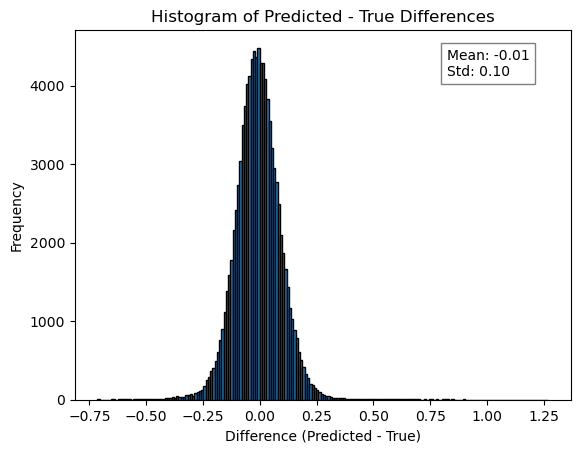

In [16]:
print(len(differences))

# Create a histogram of the differences
plt.hist(differences, bins=200, edgecolor='black')
plt.xlabel('Difference (Predicted - True)')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted - True Differences')

# Add text box with mean and standard deviation
text_box = f"Mean: {mean_difference:.2f}\nStd: {std_difference:.2f}"
plt.text(0.75, 0.95, text_box, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
plt.show()

100535


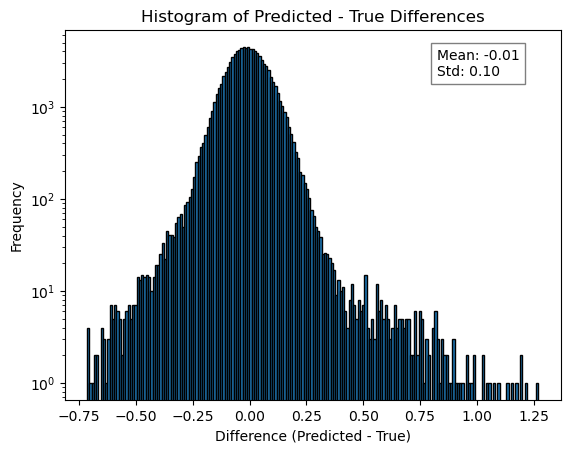

In [17]:
print(len(differences))

# Create a histogram of the differences
plt.hist(differences, bins=200, edgecolor='black')
plt.xlabel('Difference (Predicted - True)')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted - True Differences')
plt.yscale('log')

# Add text box with mean and standard deviation
text_box = f"Mean: {mean_difference:.2f}\nStd: {std_difference:.2f}"
plt.text(0.75, 0.95, text_box, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
plt.show()

C:\Users\steve\AppData\Local\Temp\ipykernel_17432\1233265191.py:8: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for mass, group in grouped_data:


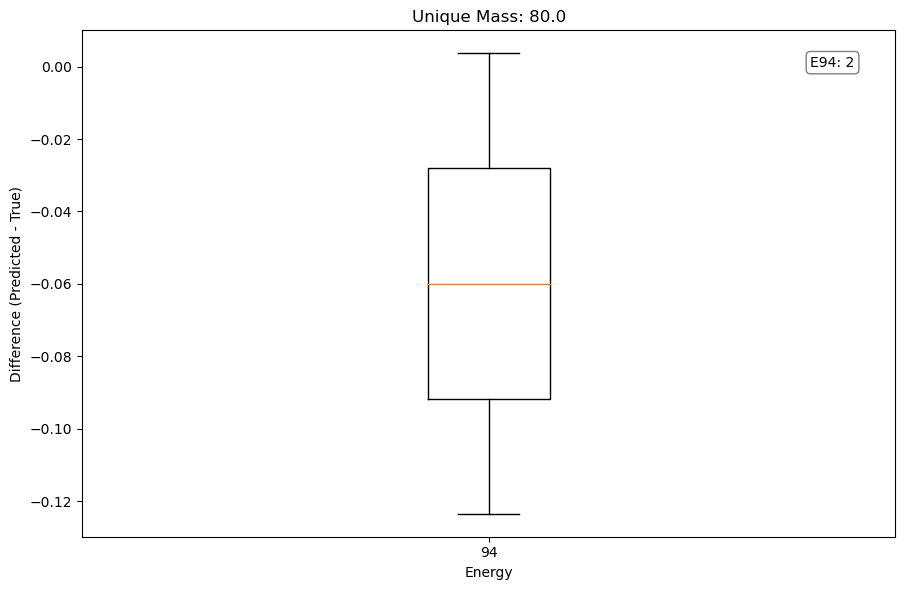

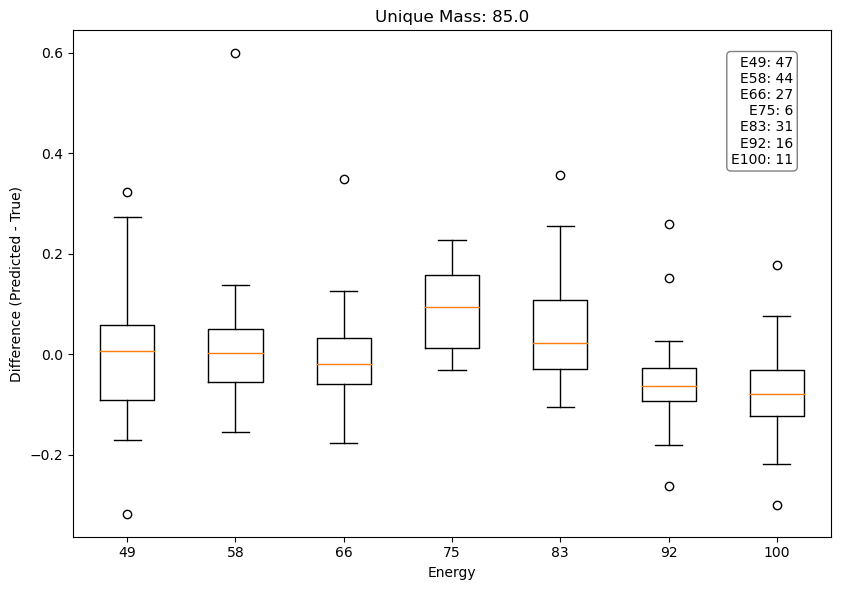

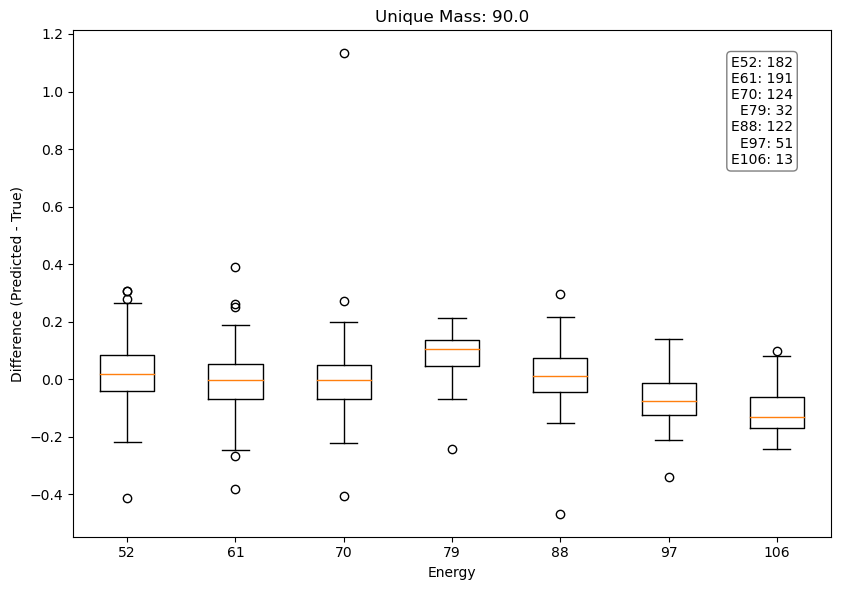

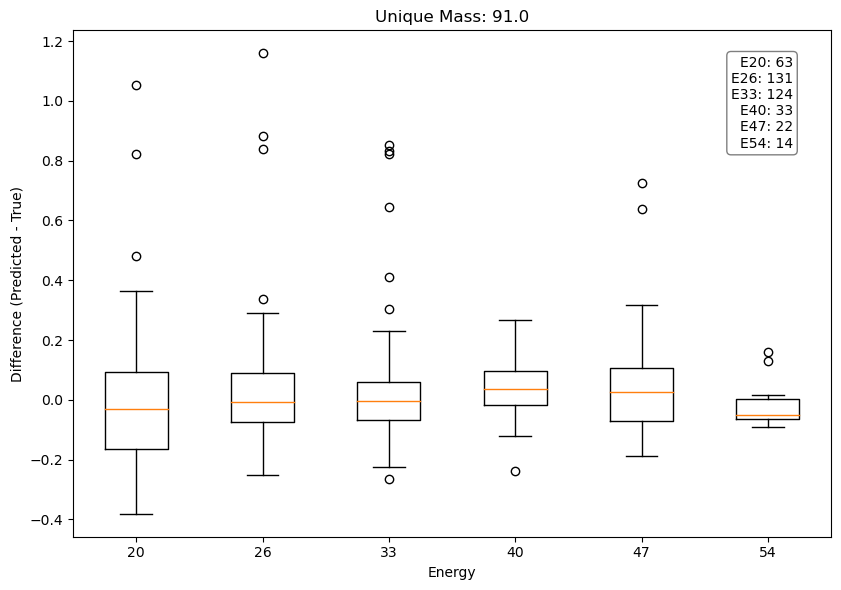

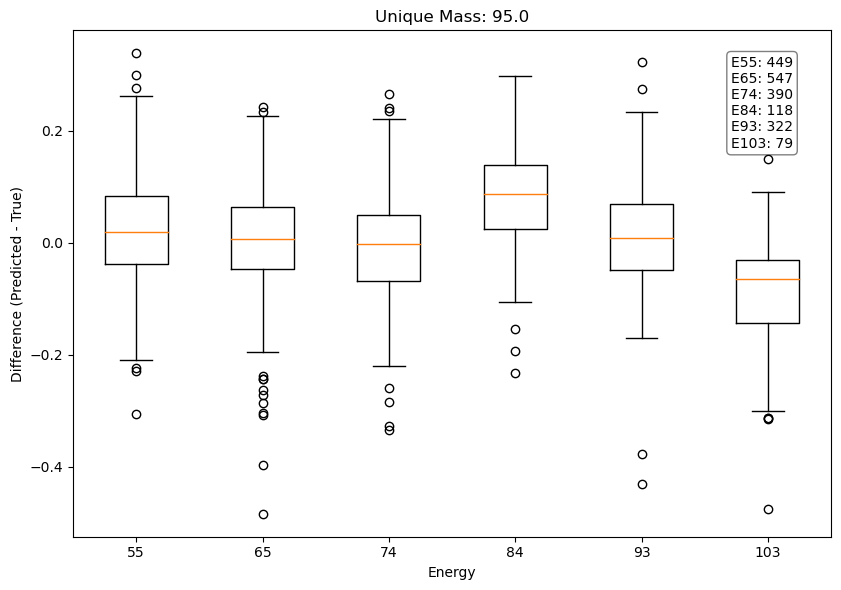

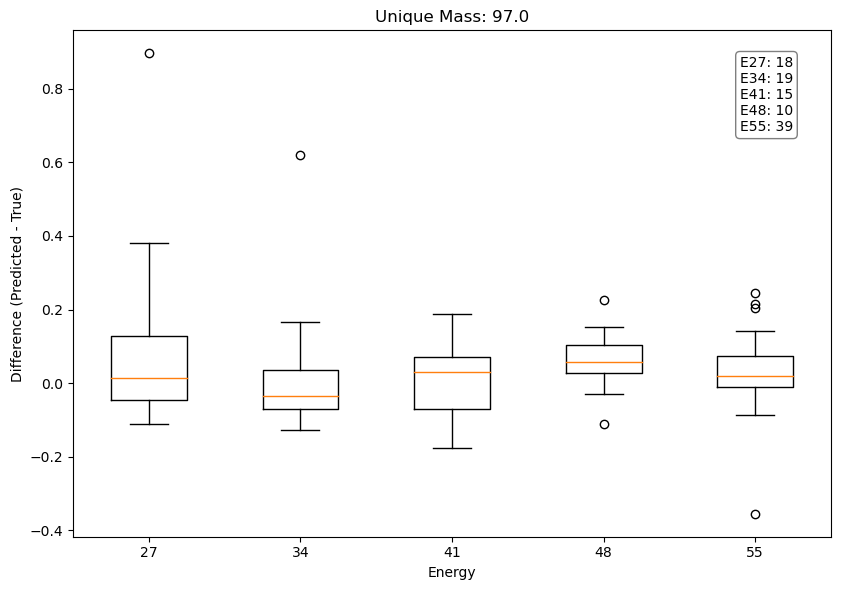

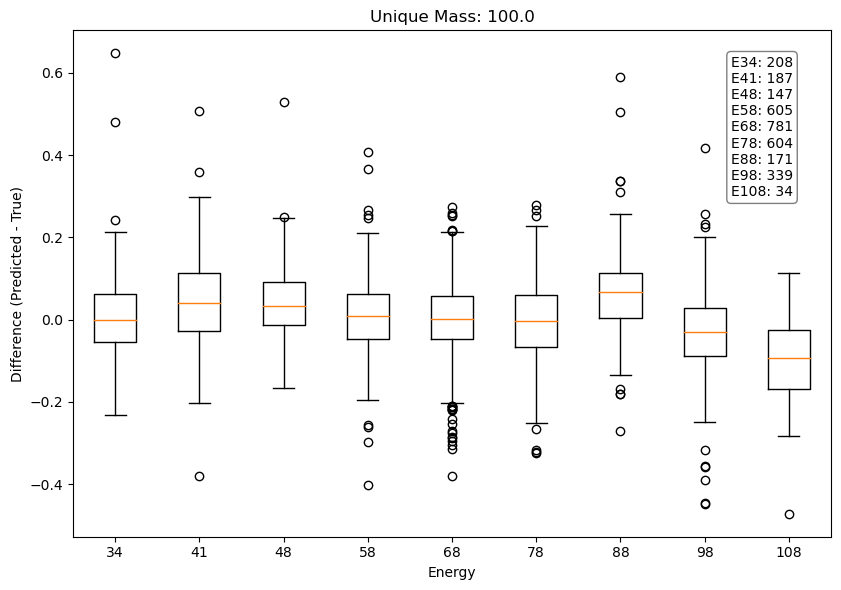

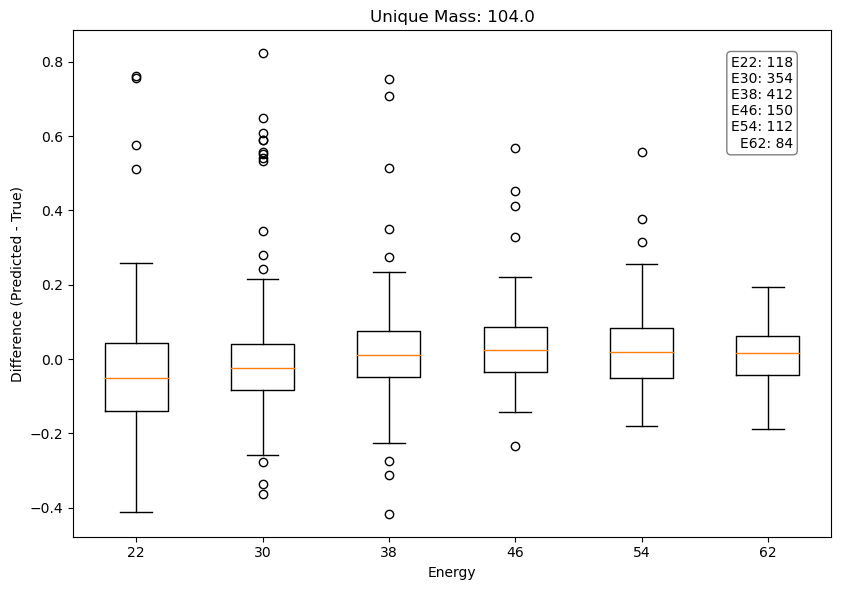

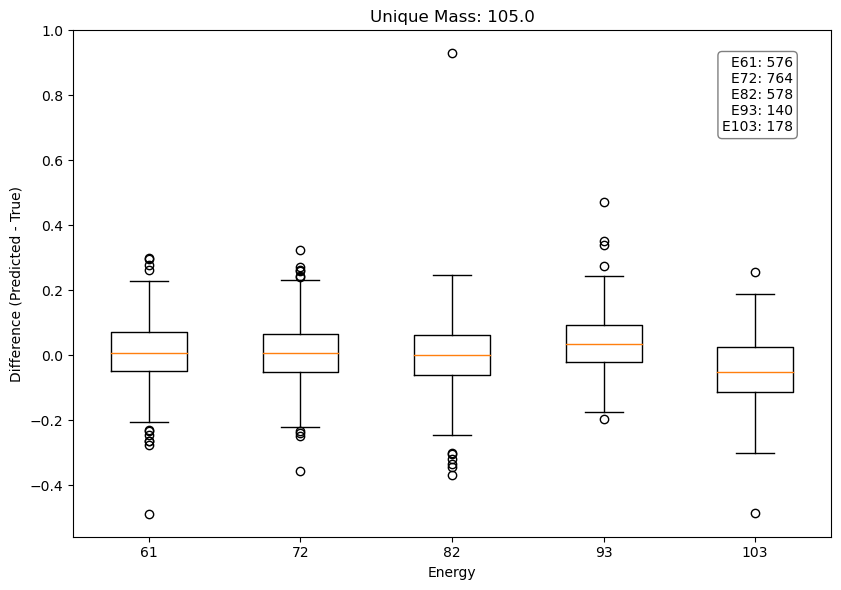

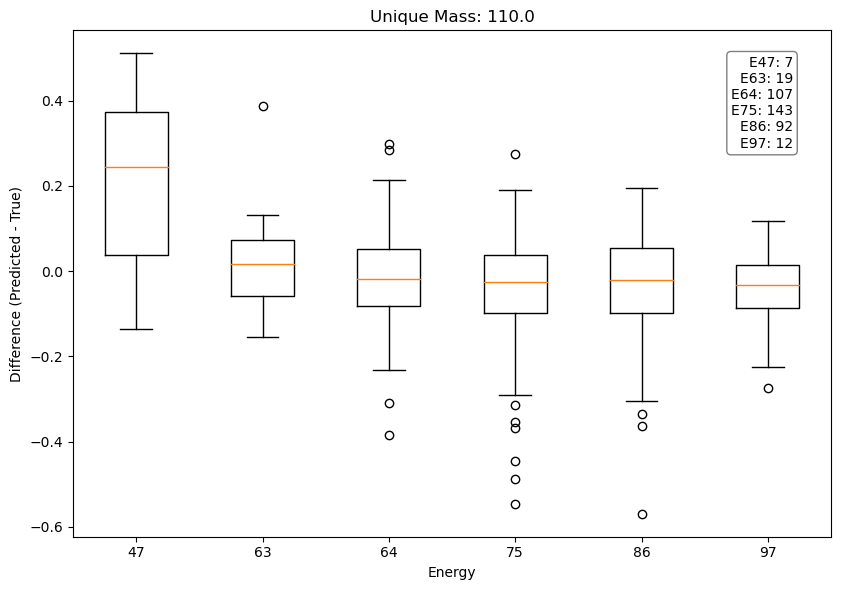

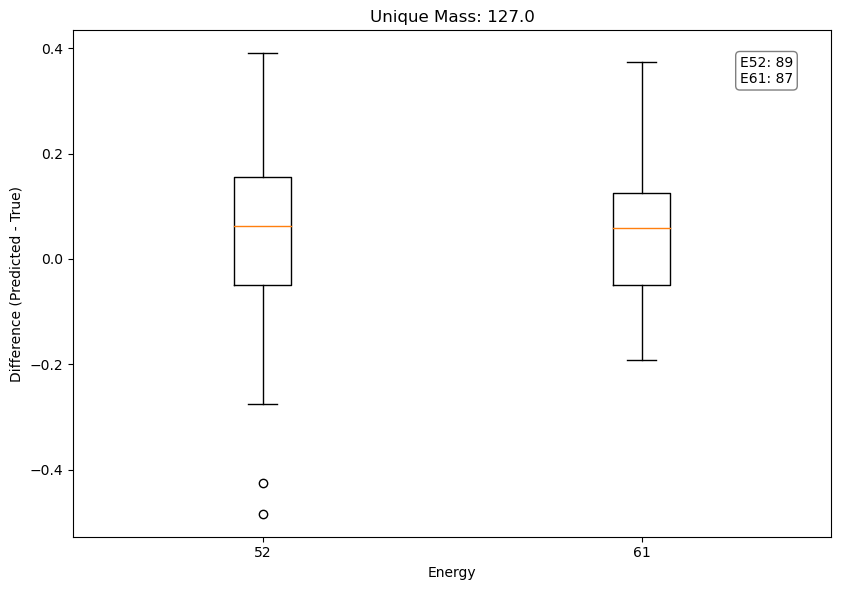

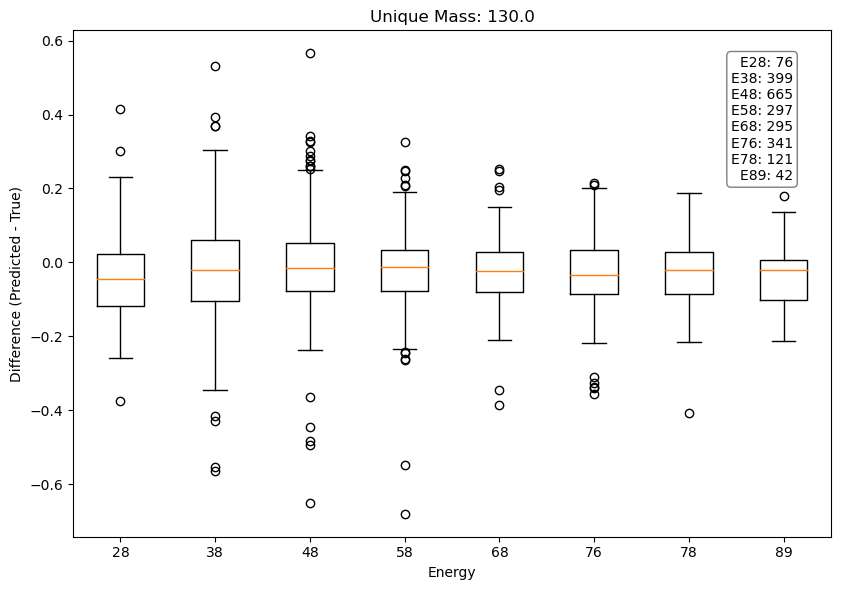

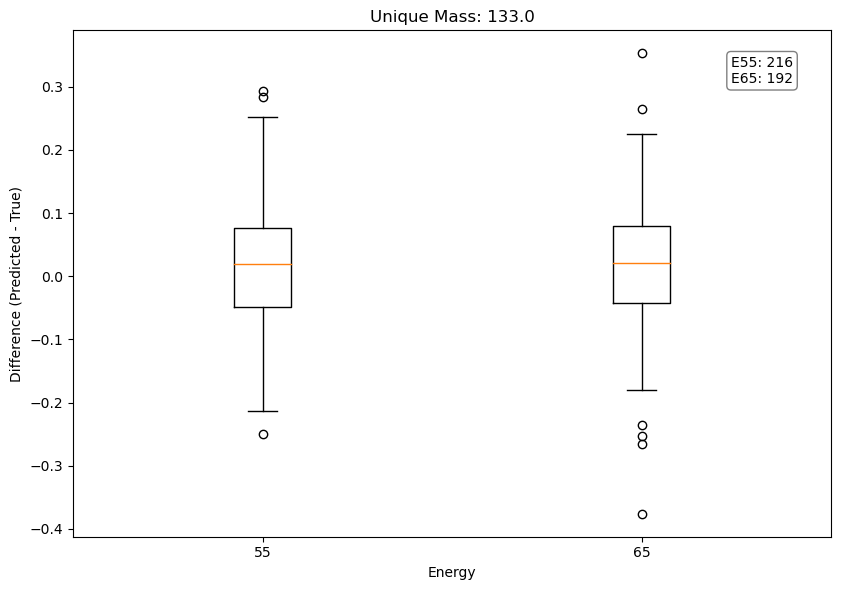

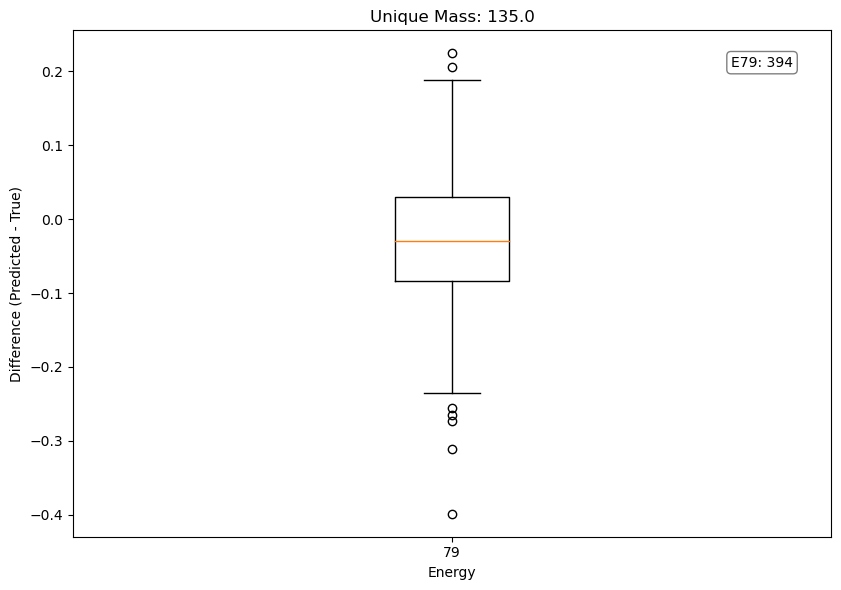

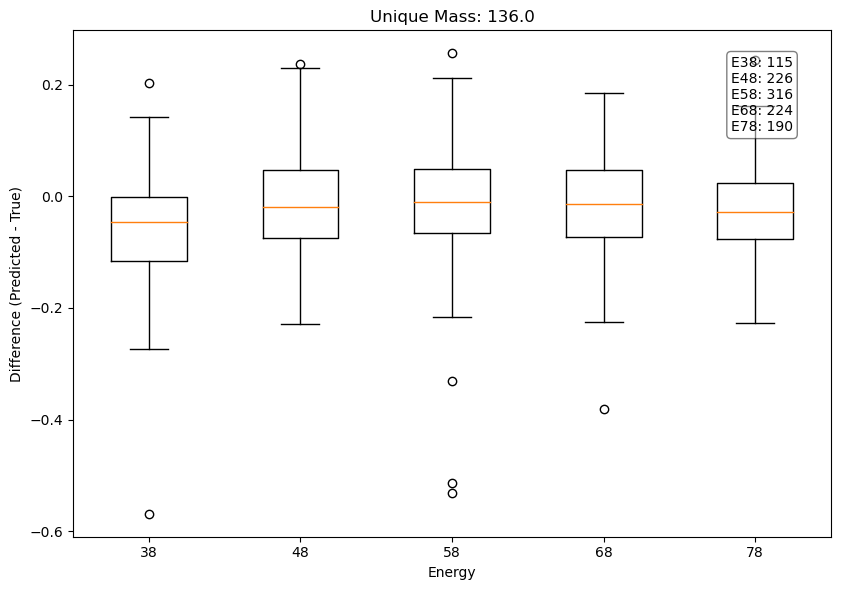

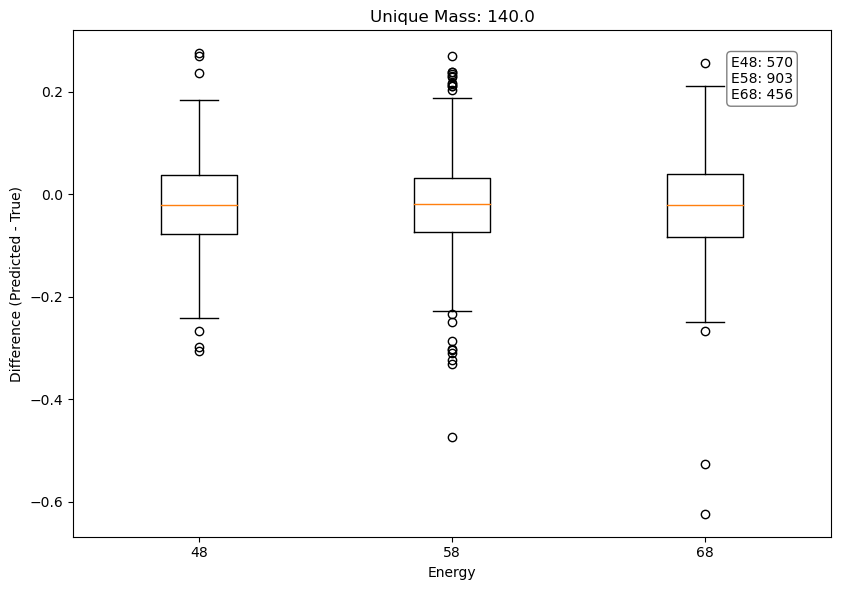

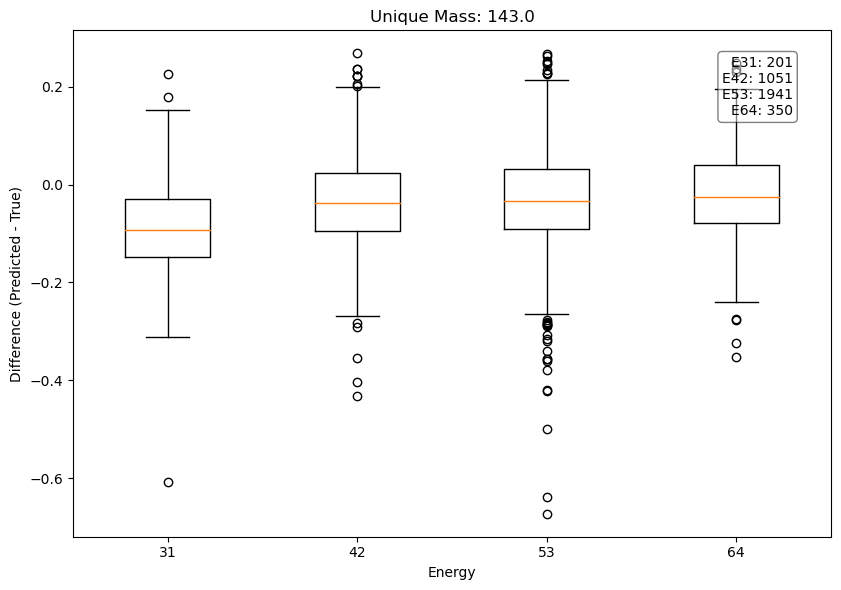

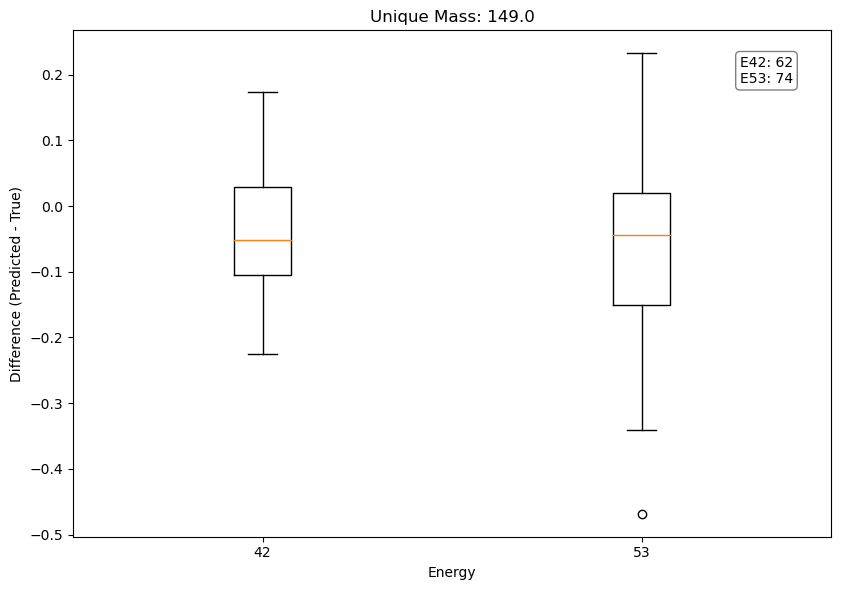

In [18]:
# Group the data by unique mass and energy
grouped_data = df_test.groupby(['A'])

# Create an empty list to store the energies for each unique mass
energies_per_mass = []

# Iterate over each unique mass group
for mass, group in grouped_data:
    energies = group['Z'].unique()  # Get the unique energies for the current mass
    energies_per_mass.append((mass, energies))  # Append the unique mass and energies tuple to the list

# Create a list to store the average test losses for each unique mass
avg_test_losses = []

# Create an empty list to store the differences for each unique mass
differences_per_mass = []

# Iterate over the unique masses
for i, (mass, energies) in enumerate(energies_per_mass, 1):
    # Create a list to store the differences for the current mass
    differences = []

    # Iterate over the energies for the current mass
    for energy in energies:
        # Retrieve the data for the current mass and energy
        data = df_test[(df_test['A'] == mass) & (df_test['Z'] == energy)]
        
        # Extract the features (signals) and labels (true values)
        signals = data[data.columns[10:-2]].values
        signals = Processing[process](signals)
        signals = signals[:, :, np.newaxis]
        labels1 = data.iloc[:, 9].values
        labels2 = data['ToF'].values
        labels = labels1 + labels2

        # Predict the labels using the model
        predicted = model.predict(signals)
        predicted = np.squeeze(predicted)

        # Calculate the difference between predicted and true labels
        difference = predicted - labels
        differences.append(difference)  # Store the difference for the current energy

    differences_per_mass.append(differences)  # Store the differences for the current mass

    # Calculate the average test loss for the current mass
    avg_test_loss = np.mean(np.abs(np.concatenate(differences)))  # Concatenate the differences for all energies
    avg_test_losses.append(avg_test_loss)  # Store the average test loss

# Iterate over the unique masses and corresponding differences
for i, (mass, differences) in enumerate(zip(energies_per_mass, differences_per_mass), 1):
    energies = mass[1]  # Get the energies for the current mass

    # Sort the energies in ascending order
    sorted_energies = np.sort(energies)

    # Get the indices to reorder the differences based on the sorted energies
    indices = np.argsort(energies)
    reordered_differences = [differences[index] for index in indices]

    plt.figure(figsize=(150, 6))  # Adjust the figure size as needed
    plt.subplot(1, len(energies_per_mass), i)  # Create a subplot for each unique mass
    plt.boxplot(reordered_differences)
    plt.title(f"Unique Mass: {mass[0]}")
    plt.xlabel("Energy")
    plt.ylabel("Difference (Predicted - True)")

    # Set the x-axis tick labels to the sorted energies
    plt.xticks(range(1, len(sorted_energies) + 1), sorted_energies)

    # Add a text box with counts for each energy
    counts = [len(d) for d in reordered_differences]
    text_box = "\n".join([f"E{e}: {count}" for e, count in zip(sorted_energies, counts)])
    plt.text(0.95, 0.95, text_box, transform=plt.gca().transAxes, va='top', ha='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    plt.tight_layout()  # Adjust the spacing between subplots
    plt.show()
